# Ch07 딥러닝을 시작합니다. 
# ch07-1 인공 신경망

## 1. 패션 MNIST 




In [3]:
import keras
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

In [4]:
#데이터 크기 확인
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


훈련 데이터 : 60,000개 이미지, 28X28    
타깃 데이터 : 60,000개 이미지, 1차원 배열   

In [5]:
#테스트 세트 크기 확인
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


10,000개 이미지

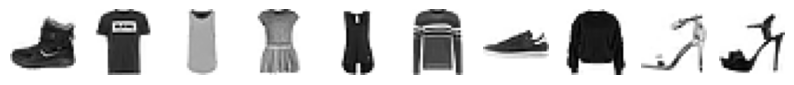

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 10, figsize = (10,10))
for i in range(10):
    axs[i].imshow(train_input[i],cmap='gray_r')
    axs[i].axis('off')
plt.show()

In [7]:
print(train_target[:10])

[9 0 0 3 0 2 7 2 5 5]


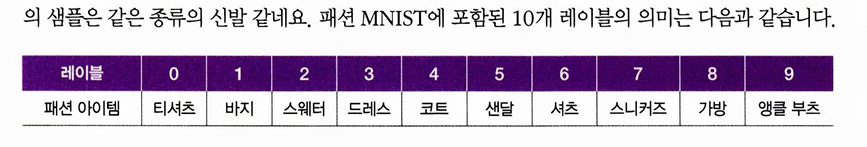

In [8]:
import numpy as np 
print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


0~9까지 레이블마다 정확히 6,000개의 샘플이 들어가 있음  

## 로지스틱 회귀로 패션 아이템 분류하기

샘플이 60,000개이므로 전체 데이터를 한꺼번에 사용하여 훈련하는 것(Batch Gradient Descent)보다       
샘플을 하나씩 꺼내서 모델을 훈련하는 방법(SGD / Mini-Batch GD)이 더 효율적임  
따라서, 확률적 경사 하강법을 사용   

--------------------------------------------------------------------------------------
✅ 왜 샘플이 많을수록 하나씩 꺼내서(SGD) 학습하는 게 더 효율적일까?     
1) 한 번에 60,000개를 모두 사용하는 것은 계산량이 너무 크기 때문        
**배치 경사하강법(BGD)**은 매 스텝마다 전체 데이터 60,000개에 대해      
    - 예측  
    - 손실 계산         
    - 경사 계산 을 수행해야 해.     
    즉, 매 스텝마다 6만 개 × 파라미터 수 연산이 필요함 → 매우 무거움.       

**SGD**는
→ 매 스텝마다 딱 1개 샘플에 대해서만 연산을 수행.

✔ 연산량이 60,000배 가벼워짐.


2) 반복 횟수가 더 많아도, 각각의 연산이 훨씬 가볍다     

- BGD: 1 epoch = 1번의 경사 계산        
- SGD: 1 epoch = 60,000번의 경사 계산       

반복은 많아지지만 각 반복의 비용이 압도적으로 낮다.     

예:     
BGD: 1 step = 0.3초     
SGD: 1 step = 0.00001초 → 60,000번 = 0.6초       
➜ 총 비용은 SGD가 훨씬 낮다.         


3) SGD는 곡면 모양에 더 빨리 적응한다 → 최적점까지 훨씬 빠르게 간다         
배치 GD는 매 스텝마다 전체 평균 경사를 쓰므로:      
    이동 속도 느림      
    지그재그 없이 천천히 움직임     
    반면 SGD는 데이터 하나씩 보면서 자주 업데이트하므로:        

“탐색하면서” 빠르게 하강    
로컬미니마에서 빠져나오기 쉬움  
최적점 근처로 빨리 도달 
즉, 초기 수렴 속도는 SGD가 압도적으로 빠르다.   

4) 대규모 데이터 학습에서 BGD는 거의 사용되지 않는다    

딥러닝에서 조차도 100% 항상 미니배치 학습을 사용해. 

왜냐하면:

방법	한 스텝 연산량	수렴 속도	실전 사용
Batch GD	매우 큼	느림	거의 안 씀
SGD	매우 작음	매우 빠름	종종 사용
Mini-Batch GD	적당함	빠름 + 안정적	표준 방식
🔥 핵심 직관
✔ Batch = 정확한 방향이지만 너무 비싼 연산
✔ SGD = 개별 데이터 기반의 noisy한 방향이지만 빠르게 움직임
✔ 데이터가 많을수록 → 배치 방식이 기하급수적으로 느려짐
✔ 그래서 데이터가 많으면 → SGD 또는 미니배치가 더 효율적임
🔍 비유로 쉽게 이해하면
● 배치 GD

매번 6만 명의 의견을 다 듣고 결정하는 방식
→ 시간이 오래 걸림

● SGD

한 명에게 물어보고 바로 행동하는 방식
→ 개개인의 의견은 불완전하지만
→ 빠르게 반복하면 전체 방향으로 수렴함

결론

데이터가 많을수록 한 번에 모든 샘플을 처리하는 비용이 너무 크기 때문에,
개별 샘플을 빠르게 처리하는 SGD가 전체적으로 훨씬 효율적이다.

In [9]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

In [10]:
print(train_scaled.shape)

(60000, 784)


In [11]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc= SGDClassifier(loss='log_loss', max_iter=20, random_state=42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score']))

/home/hykim/miniconda3/envs/ai-study/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/hykim/miniconda3/envs/ai-study/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/hykim/miniconda3/envs/ai-study/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/hykim/miniconda3/envs/ai-study/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to im

0.8437333333333334


/home/hykim/miniconda3/envs/ai-study/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


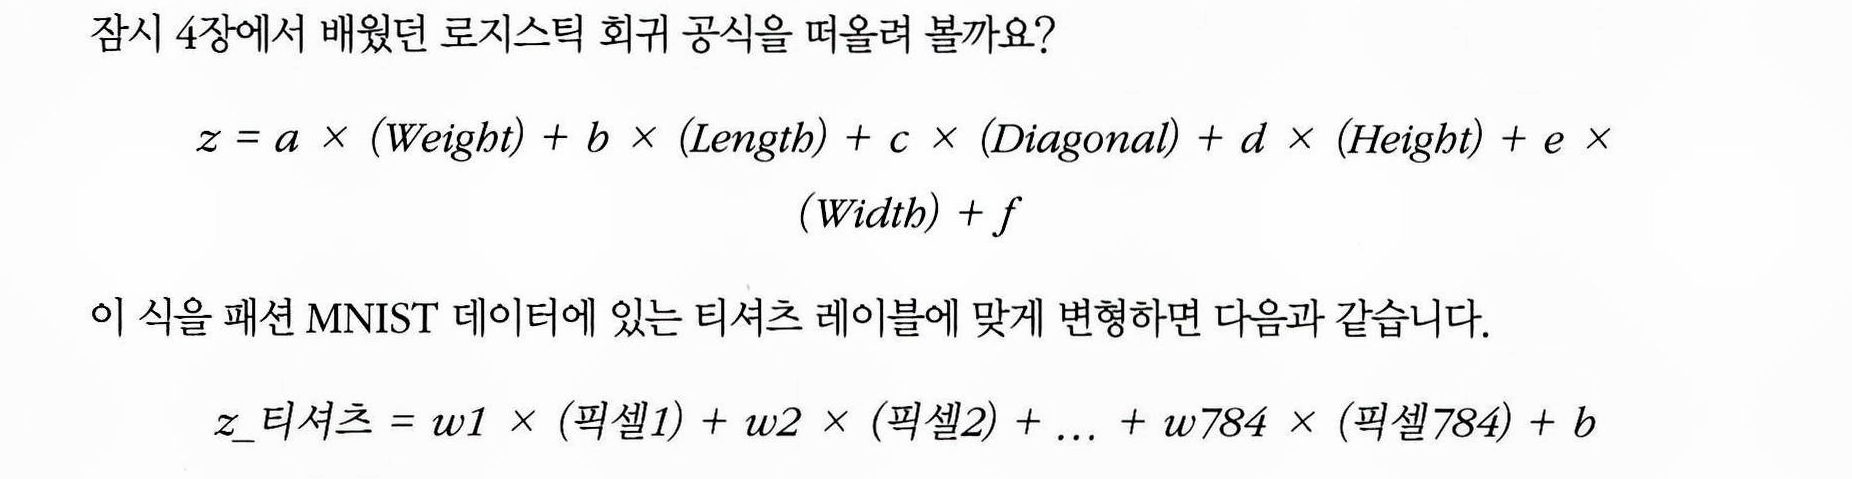
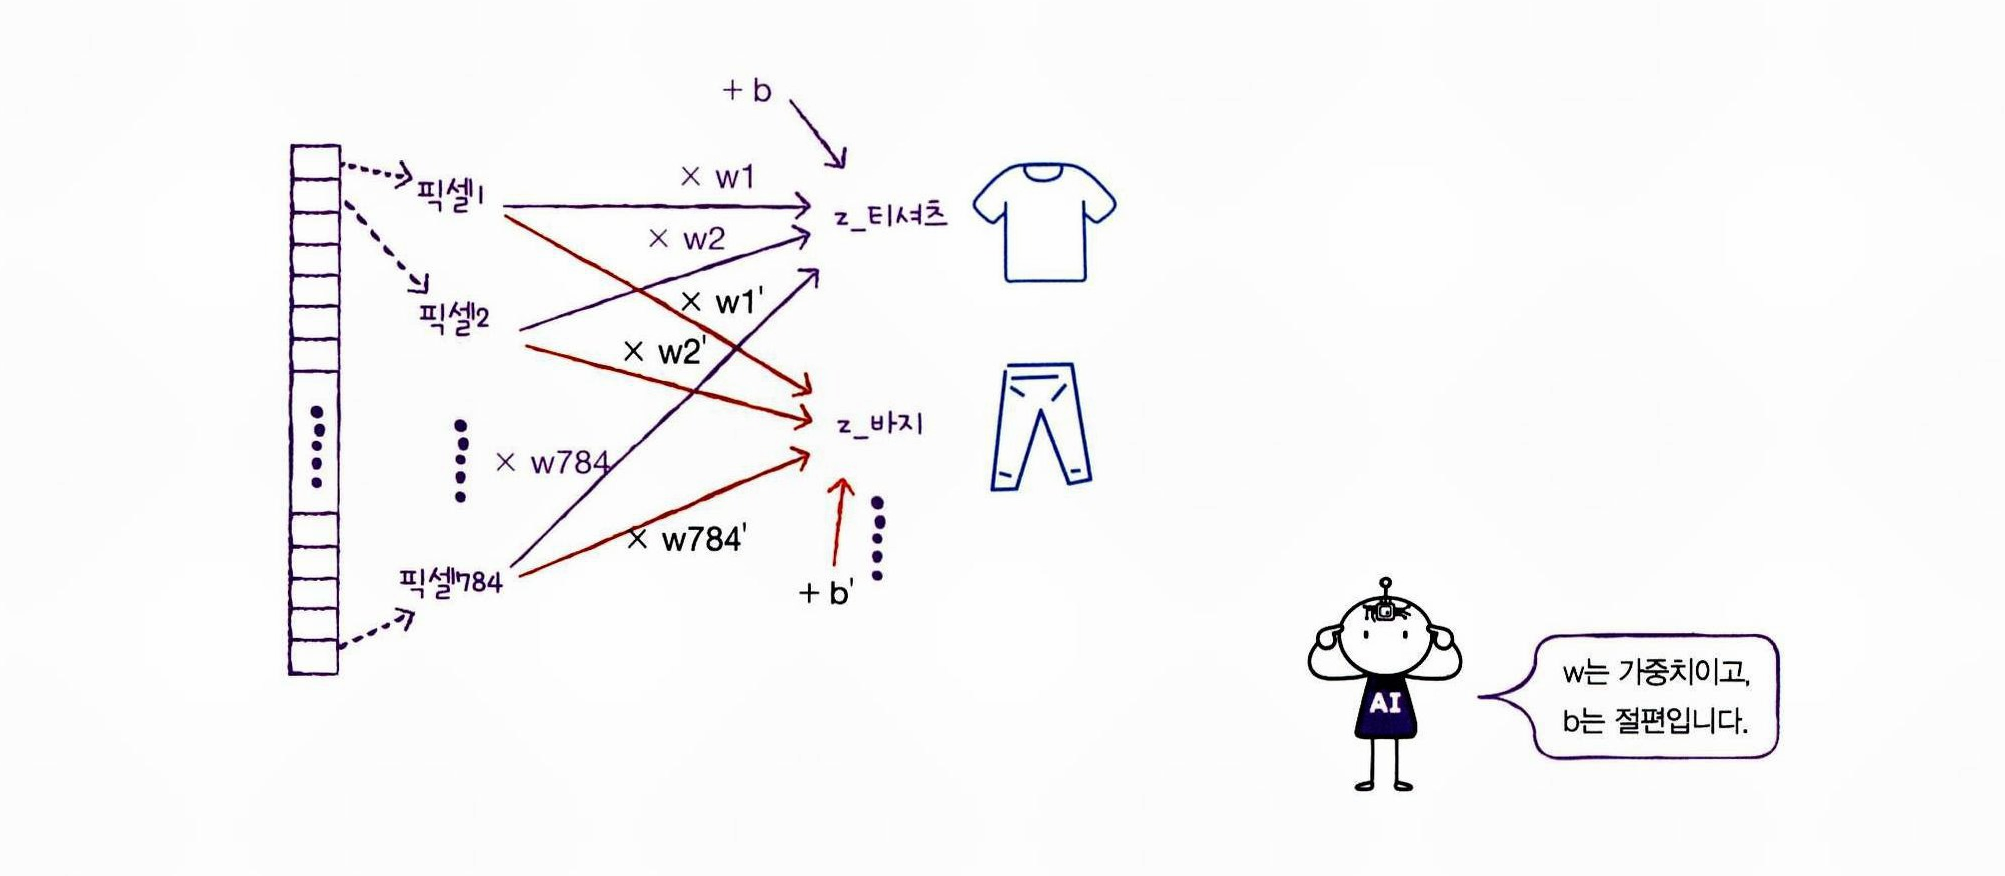


## 2

In [12]:
keras.config.backend()

'tensorflow'

In [13]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [14]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size =0.2, random_state=42
)

In [15]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [16]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


In [17]:
inputs = keras.layers.Input(shape=(784,))

In [18]:
dense = keras.layers.Dense(10, activation='softmax')

In [19]:
model = keras.Sequential([inputs, dense])

I0000 00:00:1763350852.414996    8419 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1754 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 4GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
